In [47]:
from qutip import * # qutip == 5.0.4
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
import csv


# Hamiltonian
$$\begin{align}​
H(t) &= \sum_{i = j}^{n} \frac{\Omega_j(t)}{2} |1\rangle_j {}_j\langle r| + \text{h.c.} \\​
&+ \sum_{j <> k} B_{jk} |rr\rangle_{jk} {}_{jk}\langle rr|.​
\end{align}$$

# the Two Qubit System with Infinte Blockade Strength

In [48]:
N = 99 # number of time steps
dim = 4 
basis_state = [basis(dim,i) for i in range(dim)] # basis states
# in the basis of |10>, |0r>, |11>, |W>=(|1r>+|r1>)/sqrt2

method = 'BFGS'
sqrt2 = np.sqrt(2)

Omega_max = 1 # fix maximum Omega
T_max = 1000.0 # maximum time
T_list = np.linspace(0, T_max, 100)

# Initialize the state
psi_in = Qobj([1,0,1,0]/sqrt2) # |psi(0)> = |1>|0> + |1>|1> 

In [56]:
class Optimalization_2_qubits:
    # input T get optimal 1-F and optimized phi
    def __init__(self, T):
        self.T = T
        self.dt = T/N
        self.phi = np.random.uniform(0, 2*np.pi, N) # Random initial phase angles
        
    def get_H(self):
        phi = self.phi
        
        Omega = Omega_max * np.exp(1j*phi)# Global Pulse so Omega_1 = Omega_2 = Omega

        H = np.zeros((4,4)) # Hamiltonian matrix
        # in the basis of |01>, |0r>,|11>,|W>=(|1r>+|r1>)/sqr2
        H_list = [] # List to store Hamiltonian matrices
        
        for i in range(N):
            H[0,1] = Omega[i]/2 
            H[1,0] = Omega[i].conj()/2
            H[2,3] = Omega[i]/sqrt2
            H[3,2] = Omega[i].conj()/sqrt2
            
            H_operator = Qobj(H) # Convert to Qobj
            H_list.append(H_operator) # Append to the list
        return H_list # Return the list of Hamiltonian matrices

    def get_U(self):
        dt = self.dt
        phi = self.phi
        # Define the unitary operator
        H_list = self.get_H() # Get the Hamiltonian list
        U_total = qeye(H_list[0].dims[0]) # Initialize the total unitary operator
        for i in range(len(H_list)):
            H_i = H_list[i]               # Calculate the Hamiltonian for the current time step
            U_i = (-1j * H_i * dt).expm() 
            U_total = U_i * U_total
        return U_total # Return the total unitary operator

    def get_fidelity(self):
        
        # use the average fidelity fomula
        U = self.get_U()
        
        # a01 = basis_state[0].dag() * U * psi_in 
        # a11 = -basis_state[2].dag() * U * psi_in 
        a01 = basis_state[0].dag() * U * basis_state[0]
        a11 = -basis_state[2].dag() * U * basis_state[2]

        F = (0.05) * ( np.abs(1 + 2*a01 + a11)**2 + 1 + 2*np.abs(a01)**2 + np.abs(a11)**2 )
        return F # Return the fidelity

    def objective_function(self, phi):
        self.phi = phi # Update phi
        return 1-self.get_fidelity()
    
    def optimize(self):
        # Optimize the phase angles
        result = minimize(self.objective_function, self.phi, method='BFGS', options={'disp': False})
        return result.fun, result.x
    
    def repeat_optimize(self,num=10):
        # Repeat the optimization process to find the best fidelity
        best_result = 1.0
        best_phi = np.zeros(N)
        for i in range(10):
            self.phi = np.random.uniform(0, 2*np.pi, N)
            result = self.optimize()
            if result[0] < best_result:
                best_result = result[0]
                best_phi = result[1]
        return best_result, best_phi
    
def optimize_test(T_sample,total):
    # try to find the optimal phi from several random phi and get the best result

    results = []
    count_optimal = 0
    count = 0

    for i in range(total):
        count += 1
        sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
        result = sample.optimize() # Optimize the phase angles
        if result[0] < 0.1:
            count_optimal += 1
        results.append(result[0]) # Append the minimum fidelity to the results list
        print(f" progress:{count}/{total}, probility: {count_optimal/count},minimum fidelity: {np.min(results)}")
        

    plt.hist(results, bins=10, density=False, alpha=0.7,rwidth=0.8 ,color='blue',label = 'toltal = 10')
    plt.title('Frequency distribution histogramof 1-F')
    plt.ylabel('Frequency')
    plt.xlabel('1-F')
    plt.grid(True)
    plt.legend()
    plt.show()
            

    

In [35]:
T_sample = 10.0
sample = Optimalization_2_qubits(T_sample)
U = sample.get_U()
U.dag() * U # Check if U is unitary

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [36]:
# test the optimization process
T_samples = np.array([10.0**i for i in range(0,5)])

for T_sample in T_samples:
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result_in  = 1 - sample.get_fidelity() # Get the initial fidelity
    result = sample.optimize() # Optimize the phase angles
    print(f'Optimize under the same T: {T_sample}')
    print(f"initilal result: {result_in}, optimized result: {result[0]}")


Optimize under the same T: 1.0
initilal result: 0.60020561181481, optimized result: 0.6000000007478705
Optimize under the same T: 10.0
initilal result: 0.6049490716311903, optimized result: 0.6000000000002171
Optimize under the same T: 100.0
initilal result: 0.8367039095675173, optimized result: 0.6000000000000065
Optimize under the same T: 1000.0
initilal result: 0.7640909113494583, optimized result: 0.5513161543405505
Optimize under the same T: 10000.0
initilal result: 0.9018825082182941, optimized result: 0.11561967257010664


In [37]:
# test the stabullity of the optimization

results = []
phis = []
count = 0
T_sample = 1000.0
times = 10
print(f'Optimize under the same T: {T_sample}')
for i in range(times):
    count += 1
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    
    results.append(result[0]) # Append the minimum fidelity to the results list
    phis.append(result[1]) # Append the optimized phase angles to the phis list
    
    print(f"progress: {count}/{times}, minimum fidelity: {np.min(results)}")



Optimize under the same T: 1000.0
progress: 1/10, minimum fidelity: 0.15981483914257044
progress: 2/10, minimum fidelity: 0.06381649262193634
progress: 3/10, minimum fidelity: 0.06381649262193634
progress: 4/10, minimum fidelity: 0.06381649262193634
progress: 5/10, minimum fidelity: 0.06381649262193634
progress: 6/10, minimum fidelity: 0.06381649262193634
progress: 7/10, minimum fidelity: 0.0010686083172412042
progress: 8/10, minimum fidelity: 0.0010686083172412042
progress: 9/10, minimum fidelity: 0.0010686083172412042
progress: 10/10, minimum fidelity: 0.0010686083172412042


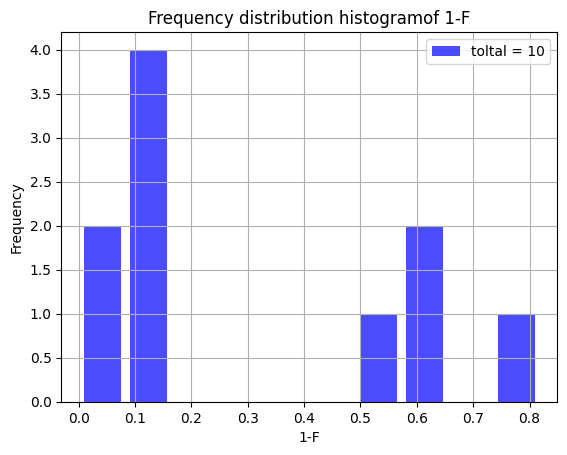

In [38]:
plt.hist(results, bins=10, density=False, alpha=0.7,rwidth=0.8 ,color='blue',label = 'toltal = 10')
plt.title('Frequency distribution histogramof 1-F')
plt.ylabel('Frequency')
plt.xlabel('1-F')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
print(f'Minimum result:{np.min(results)}')

Minimum result:0.0010686083172412042


In [42]:
result_plot = []
count = 0 
for T in T_list:
    count += 1

    sample = Optimalization_2_qubits(T) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    result_plot.append(result[0]) # Append the minimum fidelity to the results list
    print(f"omptimize under the time: {T}, optimized result: {result[0]}")
    print(f"progress: {count}/{len(T_list)}")

omptimize under the time: 0.0, optimized result: 0.6
progress: 1/100
omptimize under the time: 10.1010101010101, optimized result: 0.6000000207526403
progress: 2/100
omptimize under the time: 20.2020202020202, optimized result: 0.6000000030574901
progress: 3/100
omptimize under the time: 30.3030303030303, optimized result: 0.6000000000000001
progress: 4/100
omptimize under the time: 40.4040404040404, optimized result: 0.6000000001264632
progress: 5/100
omptimize under the time: 50.505050505050505, optimized result: 0.5999999999999999
progress: 6/100
omptimize under the time: 60.6060606060606, optimized result: 0.7943949833545181
progress: 7/100
omptimize under the time: 70.7070707070707, optimized result: 0.6000000000019459
progress: 8/100
omptimize under the time: 80.8080808080808, optimized result: 0.0357920377620512
progress: 9/100
omptimize under the time: 90.9090909090909, optimized result: 0.7943949833544526
progress: 10/100
omptimize under the time: 101.01010101010101, optimized

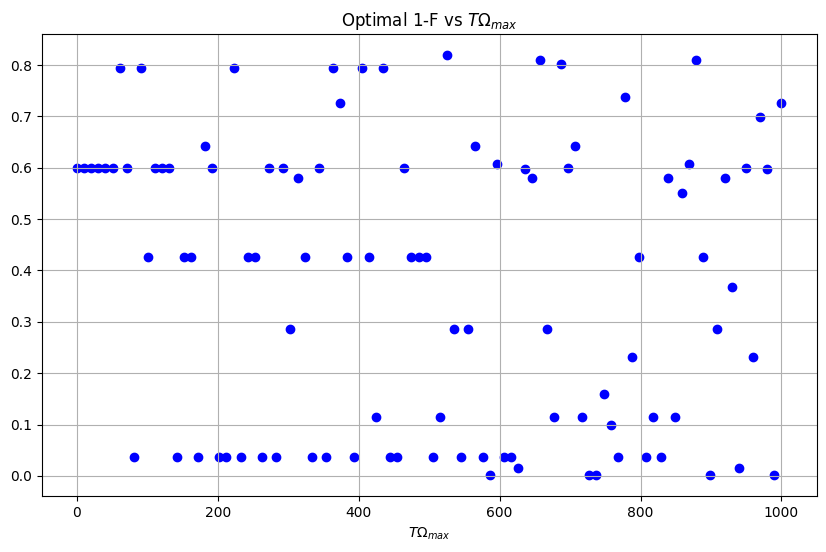

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(T_list, result_plot, color='blue', marker='o')
plt.title(r"Optimal 1-F vs $T\Omega_{max}$")
plt.xlabel(r'$T \Omega_{max}$')

plt.grid(True)
plt.show()

In [46]:
T_sample = 100.0
results = []
count_optimal = 0
count = 0
total = 30
for i in range(total):
    count += 1
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    if result[0] < 0.1:
        count_optimal += 1
    results.append(result[0]) # Append the minimum fidelity to the results list
    print(f" progress:{count}/{total}, probility: {count_optimal/count},minimum fidelity: {np.min(results)}")

 progress:1/30, probility: 0.0,minimum fidelity: 0.7943949833672423
 progress:2/30, probility: 0.0,minimum fidelity: 0.6000000000007305
 progress:3/30, probility: 0.0,minimum fidelity: 0.6000000000007305
 progress:4/30, probility: 0.0,minimum fidelity: 0.1156196725696299
 progress:5/30, probility: 0.0,minimum fidelity: 0.1156196725696299
 progress:6/30, probility: 0.16666666666666666,minimum fidelity: 0.03579203776153217
 progress:7/30, probility: 0.14285714285714285,minimum fidelity: 0.03579203776153217
 progress:8/30, probility: 0.25,minimum fidelity: 0.03579203776153217
 progress:9/30, probility: 0.2222222222222222,minimum fidelity: 0.03579203776153217
 progress:10/30, probility: 0.2,minimum fidelity: 0.03579203776153217
 progress:11/30, probility: 0.18181818181818182,minimum fidelity: 0.03579203776153217
 progress:12/30, probility: 0.16666666666666666,minimum fidelity: 0.03579203776153217
 progress:13/30, probility: 0.15384615384615385,minimum fidelity: 0.03579203776153217
 progres

In [52]:
T_sample = 10.0
total = 100

results = []
count_optimal = 0
count = 0

for i in range(total):
    count += 1
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    if result[0] < 0.1:
        count_optimal += 1
    results.append(result[0]) # Append the minimum fidelity to the results list
    print(f" progress:{count}/{total}, probility: {count_optimal/count},minimum fidelity: {np.min(results)}")

 progress:1/100, probility: 0.0,minimum fidelity: 0.6000000000394068
 progress:2/100, probility: 0.0,minimum fidelity: 0.6000000000394068
 progress:3/100, probility: 0.0,minimum fidelity: 0.6000000000092939
 progress:4/100, probility: 0.0,minimum fidelity: 0.6000000000092939
 progress:5/100, probility: 0.0,minimum fidelity: 0.6000000000092939
 progress:6/100, probility: 0.0,minimum fidelity: 0.6000000000092939
 progress:7/100, probility: 0.0,minimum fidelity: 0.6000000000092939
 progress:8/100, probility: 0.0,minimum fidelity: 0.600000000005231
 progress:9/100, probility: 0.0,minimum fidelity: 0.600000000005231
 progress:10/100, probility: 0.0,minimum fidelity: 0.6000000000006538
 progress:11/100, probility: 0.0,minimum fidelity: 0.6000000000004004
 progress:12/100, probility: 0.0,minimum fidelity: 0.6000000000004004
 progress:13/100, probility: 0.0,minimum fidelity: 0.6000000000004004
 progress:14/100, probility: 0.0,minimum fidelity: 0.6000000000004004
 progress:15/100, probility: 0.

In [ ]:
T_sample = 10.0
total = 100

results = []
count_optimal = 0
count = 0

for i in range(total):
    count += 1
    sample = Optimalization_2_qubits(T_sample) # Create an instance of the class
    result = sample.optimize() # Optimize the phase angles
    if result[0] < 0.1:
        count_optimal += 1
    results.append(result[0]) # Append the minimum fidelity to the results list
    print(f" progress:{count}/{total}, probility: {count_optimal/count},minimum fidelity: {np.min(results)}")

In [31]:
T_max = 100.0
T_list = np.linspace(0, T_max, 100)
count = 0
results = []
for T in T_list:
    count += 1
    sample = Optimalization_2_qubits(T) # Create an instance of the class
    result = sample.repeat_optimize() # Optimize the phase angles
    results.append(result[0]) # Append the minimum fidelity to the results list
    print(f"omptimize under the time: {T}, optimized result: {result[0]}")
    print(f"progress: {count}/{len(T_list)}")

omptimize under the time: 0.0, optimized result: 0.6
progress: 1/100
omptimize under the time: 1.0101010101010102, optimized result: 0.6000000000328065
progress: 2/100
omptimize under the time: 2.0202020202020203, optimized result: 0.6000000000053127
progress: 3/100
omptimize under the time: 3.0303030303030303, optimized result: 0.6000000000024954
progress: 4/100
omptimize under the time: 4.040404040404041, optimized result: 0.6000000000000443
progress: 5/100
omptimize under the time: 5.050505050505051, optimized result: 0.600000000030682
progress: 6/100
omptimize under the time: 6.0606060606060606, optimized result: 0.6000000000019872
progress: 7/100
omptimize under the time: 7.070707070707071, optimized result: 0.6
progress: 8/100
omptimize under the time: 8.080808080808081, optimized result: 0.60000000001031
progress: 9/100
omptimize under the time: 9.090909090909092, optimized result: 0.6000000000002033
progress: 10/100
omptimize under the time: 10.101010101010102, optimized result

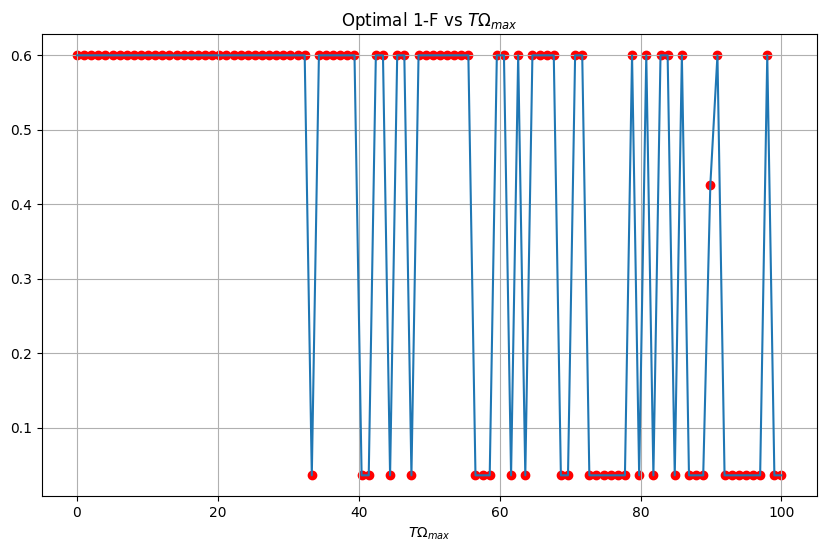

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(T_list, results)
plt.scatter(T_list, results, color='red', marker='o')
plt.title(r"Optimal 1-F vs $T\Omega_{max}$")
plt.xlabel(r'$T \Omega_{max}$')

plt.grid(True)
plt.show()

In [ ]:
# fore the 1-F to decrease along with T
T_min = 25.0
T_max = 40.0
T_list = np.linspace(T_min, T_max, 10)
count = 0
results = []
tolerance = 0.01

for T in T_list:
repeat = 1
    result = (1, np.zeros(N)) # Initialize result
    count += 1
    if results:
        results_min = np.min(results)
        while result[0] > results_min + tolerance:
            # print(f"repeat: {repeat}, result: {result[0]},results_min: {results_min}")
            repeat += 1
            
            sample = Optimalization_2_qubits(T) # Create an instance of the class
            result = sample.repeat_optimize() # Optimize the phase angles

            if repeat > 100:
                print(f"fail to decrase")
                results.append(result[0]) # Append the minimum fidelity to the results list
                break
        else:
            results.append(result[0]) # Append the minimum fidelity to the results list
            pass
    else:
        sample = Optimalization_2_qubits(T)
        result = sample.repeat_optimize()
        results.append(result[0])
    
    print(f"omptimize under the time: {T}, optimized result: {result[0]},repeat: {repeat}")
    print(f"progress: {count}/{len(T_list)}")

omptimize under the time: 25.0, optimized result: 0.6000000000000008,repeat: 1
progress: 1/10
omptimize under the time: 26.666666666666668, optimized result: 0.03579203776159312,repeat: 2
progress: 2/10


KeyboardInterrupt: 

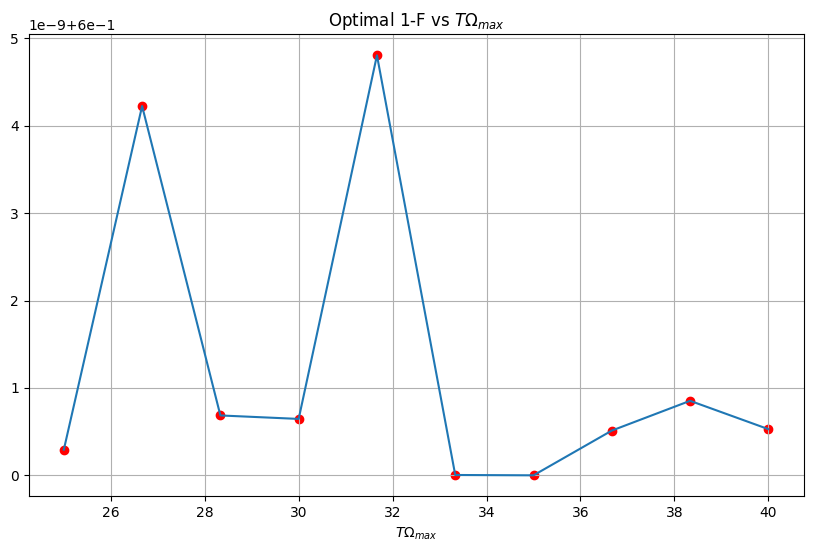

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(T_list, results)
plt.scatter(T_list, results, color='red', marker='o')
plt.title(r"Optimal 1-F vs $T\Omega_{max}$")
plt.xlabel(r'$T \Omega_{max}$')

plt.grid(True)
plt.show()

In [ ]:
optimize_test(25,100)

 progress:1/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:2/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:3/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:4/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:5/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:6/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:7/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:8/100, probility: 0.0,minimum fidelity: 0.6000000000007448
 progress:9/100, probility: 0.0,minimum fidelity: 0.6000000000000381
 progress:10/100, probility: 0.0,minimum fidelity: 0.6000000000000054
 progress:11/100, probility: 0.0,minimum fidelity: 0.6000000000000054
 progress:12/100, probility: 0.0,minimum fidelity: 0.6000000000000054
 progress:13/100, probility: 0.0,minimum fidelity: 0.5999999999999995
 progress:14/100, probility: 0.0,minimum fidelity: 0.5999999999999995
 progress:15/100, probility: 